In [1]:
## Advanced Lane Finding Project

##The goals / steps of this project are the following:

#* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
#* Apply a distortion correction to raw images.
#* Use color transforms, gradients, etc., to create a thresholded binary image.
#* Apply a perspective transform to rectify binary image ("birds-eye view").
#* Detect lane pixels and fit to find the lane boundary.
#* Determine the curvature of the lane and vehicle position with respect to center.
#* Warp the detected lane boundaries back onto the original image.
#* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

#---
## First, I'll compute the camera calibration using chessboard images

In [2]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip
from IPython.display import HTML




In [3]:
#Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

Text(0.5,1,'Undistorted Images')

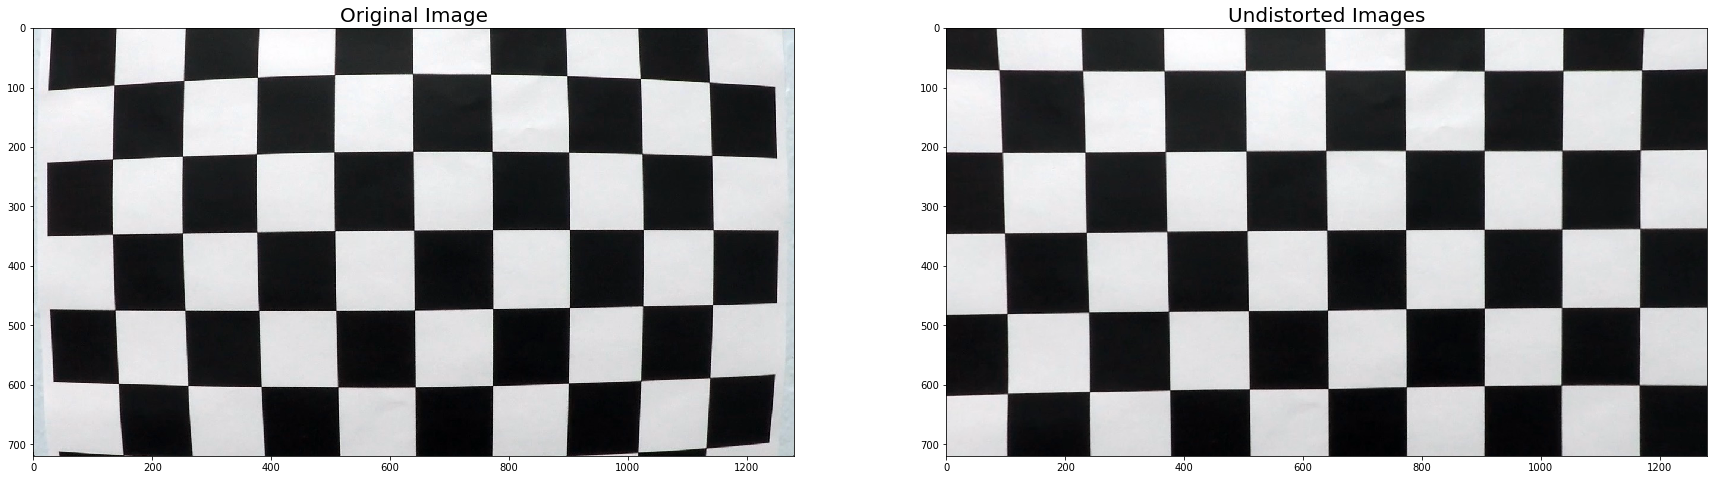

In [4]:
#Define Undistortion Function

img = cv2.imread('camera_cal/calibration1.jpg')


def Image_undistort(img):
    #Creating an array for object Points
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    nx = 9 # the number of inside corners in x
    ny = 6 # the number of inside corners in y

    objpoints=[] #3D points in real space 
    imgpoints=[] #2D points in img space

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    for index,image in enumerate(images):
        originalImage= cv2.imread(image)
        grayImg= cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY) #converting to Grayscale before finding Chessboard Corners

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(grayImg, (nx,ny), None)

        if(ret==True):
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Drawing Chessboard Corners
            cv2.drawChessboardCorners(originalImage, (nx,ny), corners, ret)
        
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

dst = Image_undistort(img)
f, axes= plt.subplots(1,2,figsize=(30,30))

axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=20)
axes[1].imshow(dst)
axes[1].set_title("Undistorted Images", fontsize=20)

In [5]:
#* Apply a distortion correction to raw images.

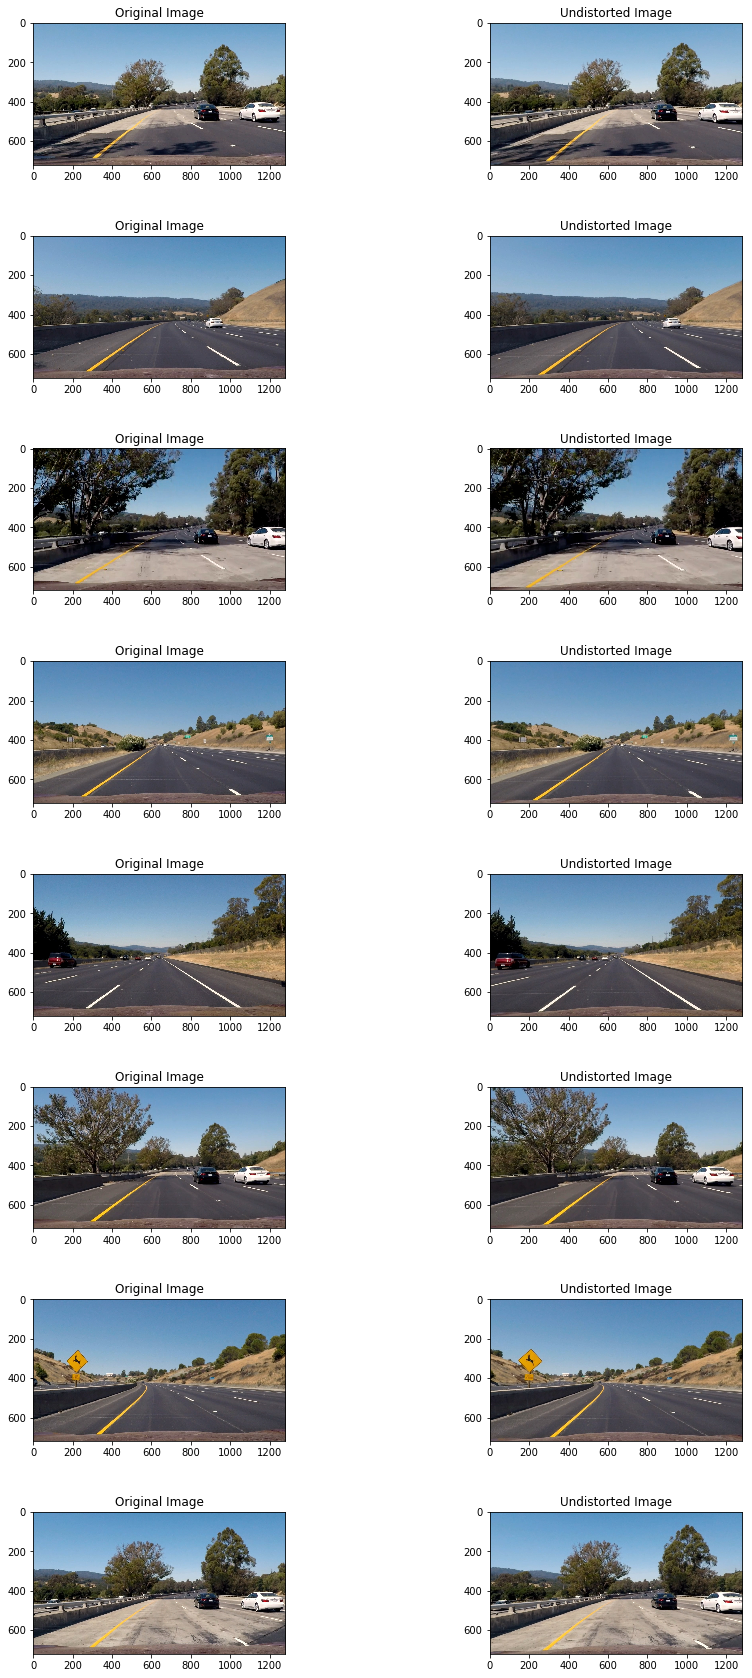

In [6]:
f, ax= plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

# Reading Images from test_images folder
images = glob.glob('test_images/*.jpg') 


for idx, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    ax[idx,0].imshow(originalImage)
    ax[idx,0].set_title("Original Image")
    undistortedImg=Image_undistort(originalImage) 
    ax[idx,1].set_title("Undistorted Image")
    ax[idx,1].imshow(undistortedImg)

In [7]:
#* Creating Camera Calibration Function

In [42]:
def camera_calibration(images, nx=9, ny=6):

    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img = None
    for fname in images:    
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    if (len(objpoints) > 0):
        # Camera successfully calibrated.
        print("Camera successfully calibrated.")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        # Unable to calibrate the camera.
        print("Unable to calibrate the camera.")
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

    return ret, mtx, dist, rvecs, tvecs
        

In [43]:
# Function to calculate Sobel X 

In [44]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    #if orient == x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)  
    # 3) Take the absolute value of the derivative or gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1)) 
        
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max

    sxbinary = np.zeros_like(scaled_sobel) 
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1 
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) # Remove this line
    return binary_output
    


In [45]:
# Function to calculate Magnitude of the Gradient

In [46]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel )
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt (sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel) 
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    binary_output = np.copy(sxbinary) # Remove this line
    return binary_output
    


In [47]:
# Function to calculate Direction of the Gradient

In [48]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel )
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(absgraddir) 
    sxbinary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) # Remove this line
    return binary_output
    


In [49]:
# Calculate Sobel X, Magnitude and Direction of the Gradient

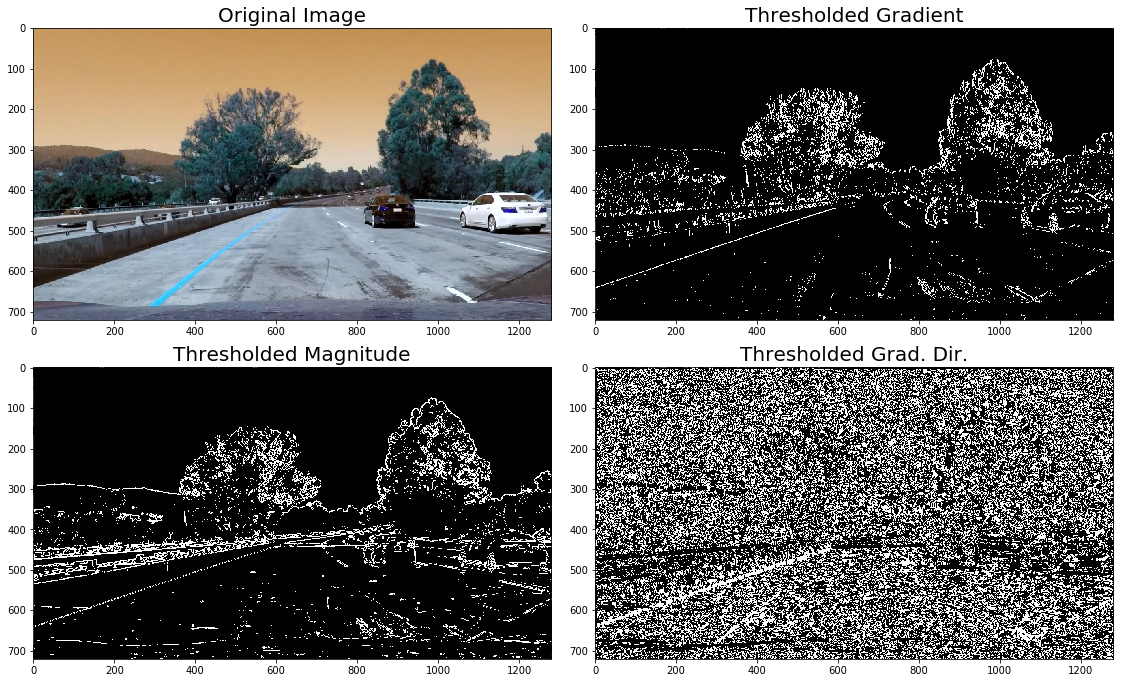

In [50]:
# Run the function

img = cv2.imread('test_images/test1.jpg')
#img = mpimg.imread('test_images/test1.jpg')

grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
#plt.imshow(grad_binary)

# Plot the result
f, ax= plt.subplots(2,2,figsize=(15,10))
f.subplots_adjust(hspace=0.5)

f.tight_layout()
ax[0,0].imshow(img)
ax[0,0].set_title('Original Image', fontsize=20)
ax[0,1].imshow(grad_binary, cmap='gray')
ax[0,1].set_title('Thresholded Gradient', fontsize=20)
ax[1,0].imshow(mag_binary, cmap='gray')
ax[1,0].set_title('Thresholded Magnitude', fontsize=20)
ax[1,1].imshow(dir_binary, cmap='gray')
ax[1,1].set_title('Thresholded Grad. Dir.', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [51]:
# Calculate gray binary of Image

In [52]:
#img = cv2.imread('test_images/test1.jpg')
img = mpimg.imread('test_images/test1.jpg')

thresh = (180, 255)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_binary = np.zeros_like(gray)
gray_binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

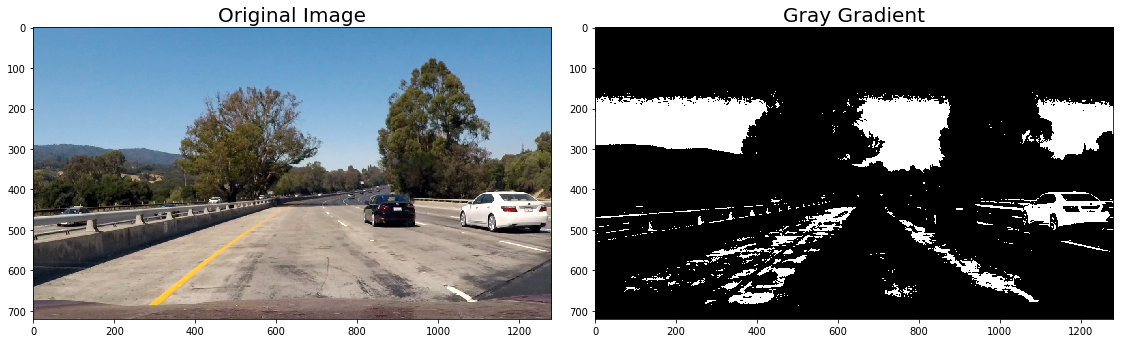

In [53]:

# Plot the result
f, ax= plt.subplots(1,2,figsize=(15,10))
f.subplots_adjust(hspace=0.5)

f.tight_layout()
ax[0].imshow(img)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(gray_binary, cmap='gray')
ax[1].set_title('Gray Gradient', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [54]:
#* Calculate color transforms to create a thresholded binary image.

In [55]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

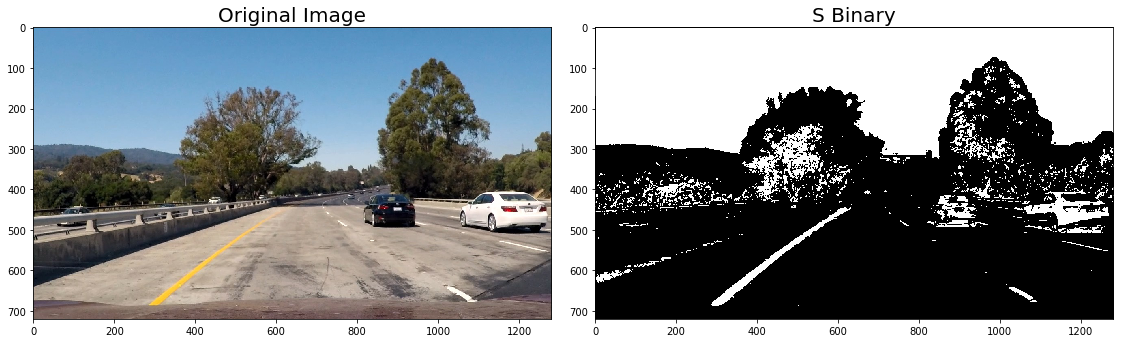

In [56]:

# Plot the result
f, ax= plt.subplots(1,2,figsize=(15,10))
f.subplots_adjust(hspace=0.5)


thresh = (90, 255)
sb_binary = np.zeros_like(S)
sb_binary[(S > thresh[0]) & (S <= thresh[1])] = 1

f.tight_layout()
ax[0].imshow(img)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(sb_binary, cmap='gray')
ax[1].set_title('S Binary', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

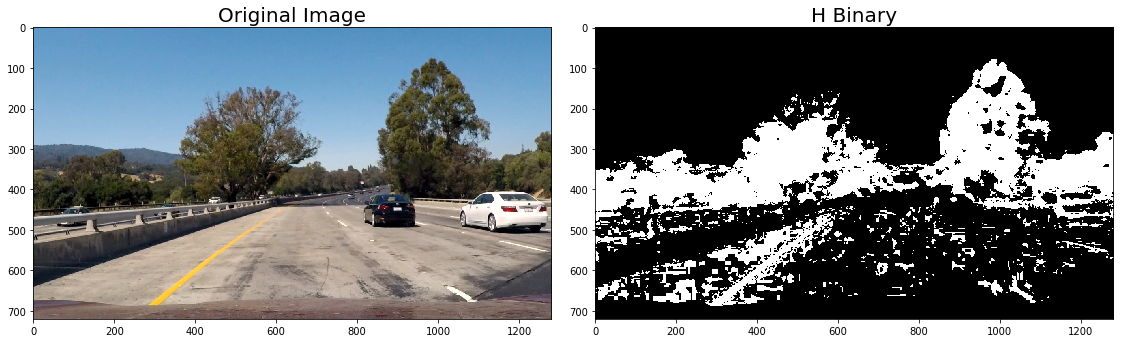

In [57]:

# Plot the result
f, ax= plt.subplots(1,2,figsize=(15,10))
f.subplots_adjust(hspace=0.5)


thresh = (15, 100)
h_binary = np.zeros_like(H)
h_binary[(H > thresh[0]) & (H <= thresh[1])] = 1
f.tight_layout()
ax[0].imshow(img)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(h_binary, cmap='gray')
ax[1].set_title('H Binary', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [58]:
#Combine color transforms and gradients to create a thresholded binary image.

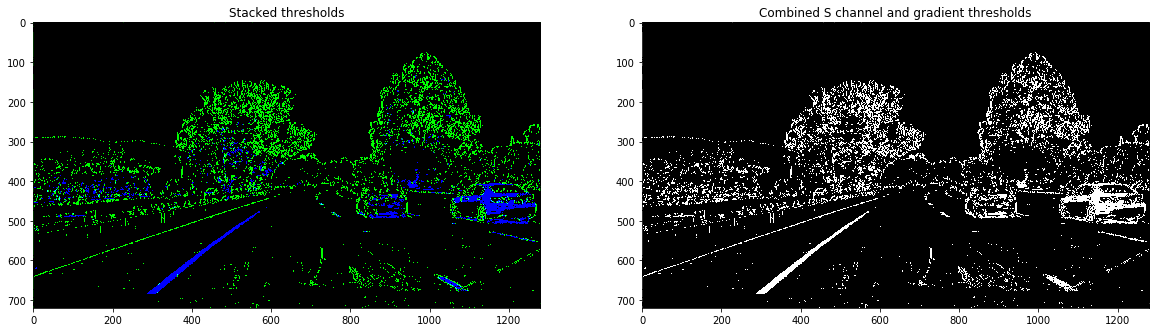

In [59]:

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

sxbinary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
#combined_binary[(gray_binary) | ((mag_binary == 1) & (dir_binary == 1)) | (sb_binary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [60]:
#* Apply a perspective transform to rectify binary image ("birds-eye view").

In [61]:
def transform_image(img, nx, ny): 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    sxbinary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    
    offset = 100 # offset for dst points
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
 
    src = np.float32([[595,460], [280,700], [725,460], [1125,700]])
    dst = np.float32([[250,0], [250,720], [1065,0], [1065,720]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_NEAREST)
    
    return warped, M, Minv

In [62]:
#* Detect lane pixels and fit to find the lane boundary.

In [63]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit

Text(0.5,1,'Result Images')

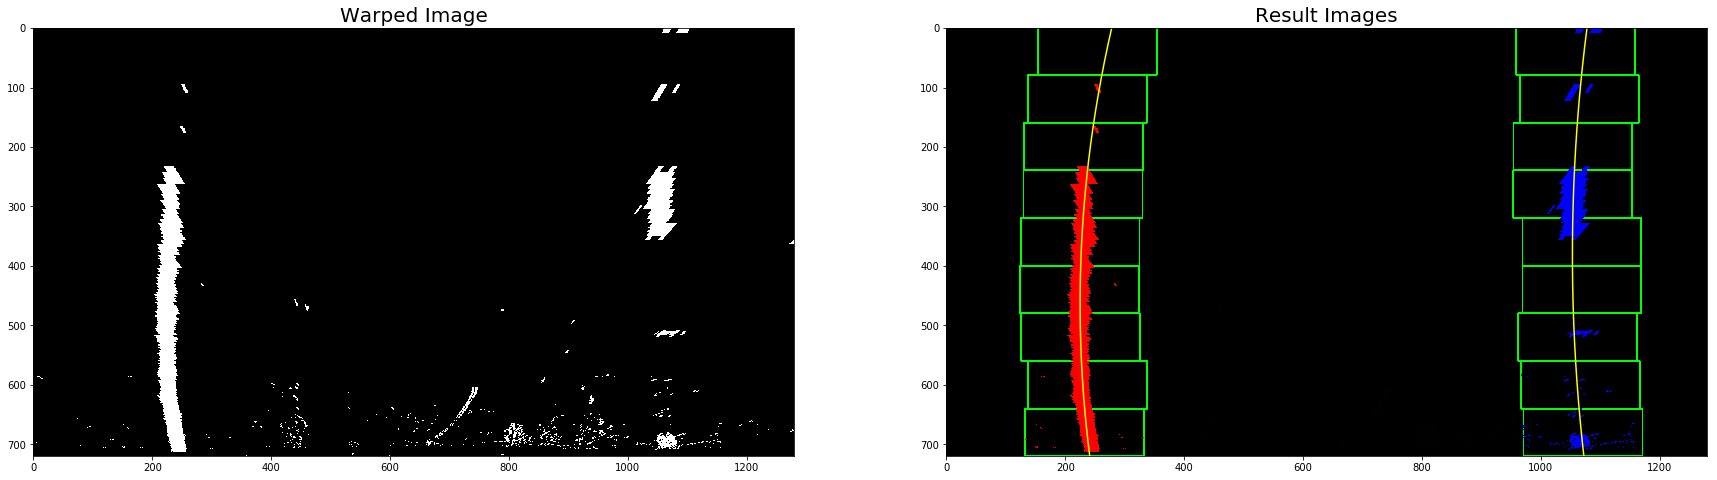

In [64]:
img = mpimg.imread('test_images/test1.jpg') 
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
warped, M, Minv = transform_image(img,nx,ny)
result,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(warped)
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
#result = search_around_poly(warped)

f, axes= plt.subplots(1,2,figsize=(30,30))

axes[0].imshow(warped, cmap='gray')
axes[0].set_title("Warped Image", fontsize=20)
axes[1].imshow(result, cmap='gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
axes[1].set_title("Result Images", fontsize=20)

In [65]:
#* Determine the curvature of the lane and vehicle position with respect to center.

In [66]:
# Polynomial fit values from the previous frame

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,left_fit,right_fit):

    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result,left_fitx,right_fitx,ploty,leftx,rightx



Text(0.5,1,'Result Images')

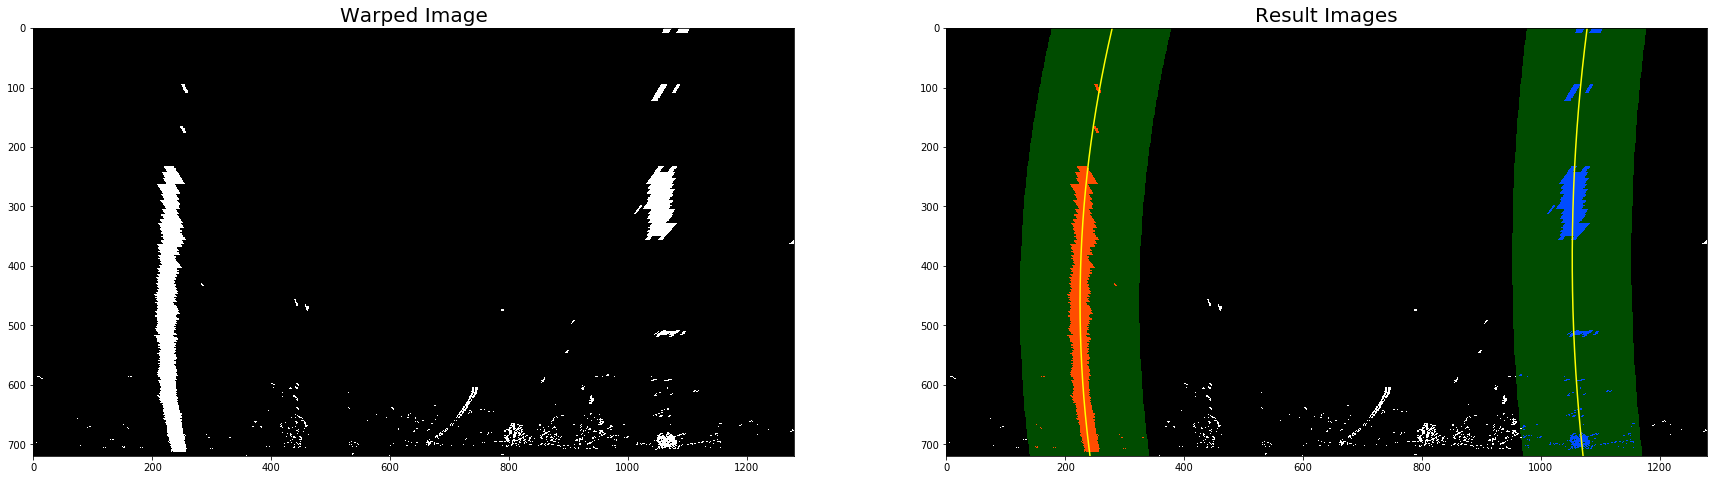

In [67]:
result,left_fitx,right_fitx,ploty,leftx,rightx = search_around_poly(warped,left_fit,right_fit)

f, axes= plt.subplots(1,2,figsize=(30,30))

axes[0].imshow(warped, cmap='gray')
axes[0].set_title("Warped Image", fontsize=20)
axes[1].imshow(result, cmap='gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
axes[1].set_title("Result Images", fontsize=20)


In [68]:
#* Warp the detected lane boundaries back onto the original image.

In [69]:
def measure_curvature_pixels(leftx, rightx, img_shape):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [70]:
curvature_rads = measure_curvature_pixels(leftx=left_fitx, rightx=right_fitx, img_shape = img.shape)

# Print the results
print('Left line curvature:', curvature_rads[0], 'm')
print('Right line curvature:', curvature_rads[1], 'm')

Left line curvature: 516.085392497 m
Right line curvature: 785.691578056 m


In [71]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

In [72]:

# Run the function
offsetx = car_offset(leftx=left_fitx, rightx=right_fitx, img_shape=img.shape)

print ('Car offset from center:', offsetx, 'm.')

Car offset from center: -0.0744321304412 m.


In [73]:
#* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [74]:
def draw_lane(img, warped_img, left_points, right_points, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points
    right_fitx = right_points

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

Text(0.5,1,'img_curv')

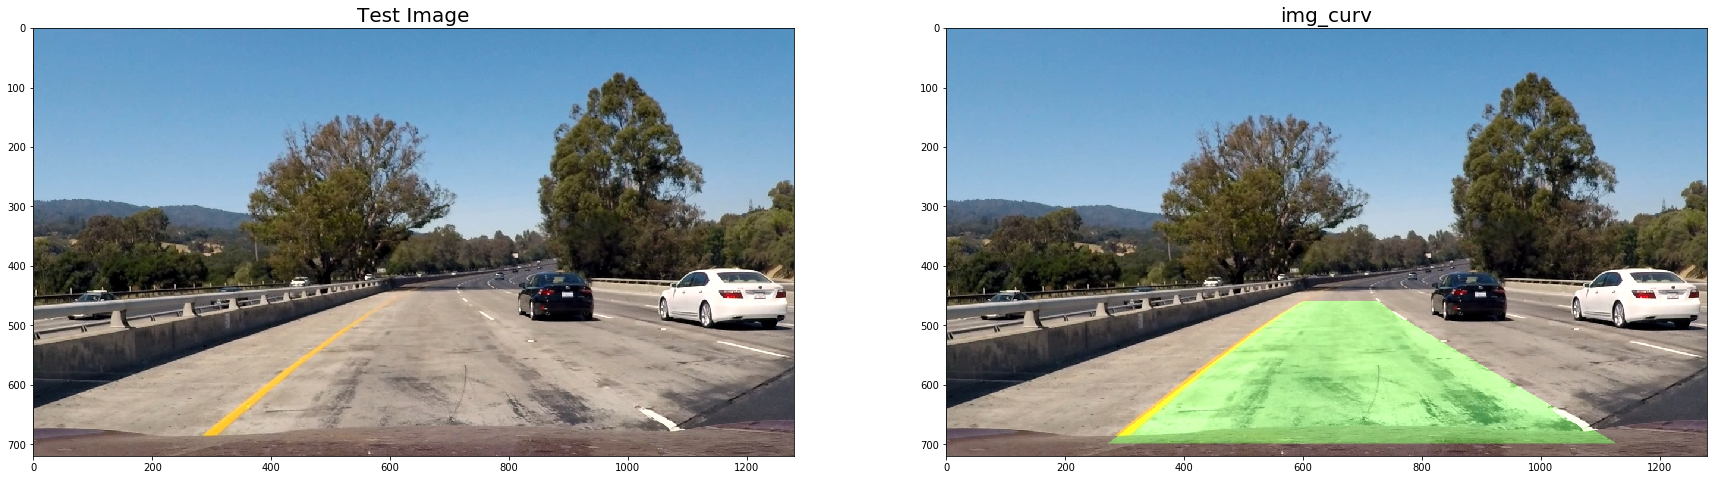

In [75]:
# Run the function
img = mpimg.imread('test_images/test1.jpg') 
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
warped, M, Minv = transform_image(img,nx,ny)

img_curv = draw_lane(img, warped, left_fitx, right_fitx,ploty, Minv)

#img_curv = draw_lane(img, warped, left_fitx, right_fitx, M)


# Plot the results

f, axes= plt.subplots(1,2,figsize=(30,30))

axes[0].imshow(img)
axes[0].set_title("Test Image", fontsize=20)
axes[1].imshow(img_curv)
axes[1].set_title("img_curv", fontsize=20)

In [76]:
def add_metrics(img, leftx, rightx):    
    # Calculate radius of curvature
    curvature_rads = measure_curvature_pixels(leftx=leftx, rightx=rightx, img_shape=img.shape)
    # Calculate car offset
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

Text(0.5,1,'Lane detected with metrics')

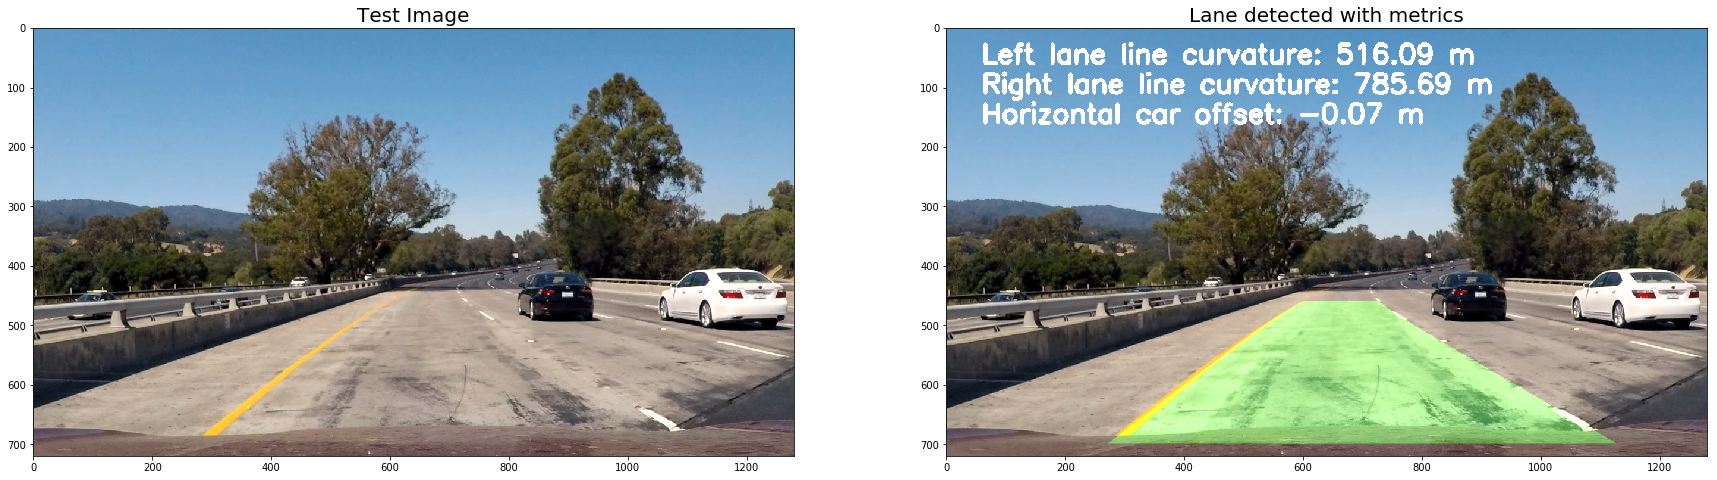

In [77]:
# Run the function
out_img = add_metrics(img_curv, left_fitx, right_fitx)

f, axes= plt.subplots(1,2,figsize=(30,30))

axes[0].imshow(img)
axes[0].set_title("Test Image", fontsize=20)
axes[1].imshow(out_img)
axes[1].set_title("Lane detected with metrics", fontsize=20)

In [78]:
 
class ProcessImage:
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)
        # Calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = camera_calibration(images)
        self.lines_fit = None

    def __call__(self, img):
        # Undistord image
        img = cv2.undistort(img, mtx, dist, None, mtx)

        nx = 9 # the number of inside corners in x
        ny = 6 # the number of inside corners in y
        warped, M, Minv = transform_image(img,nx,ny)
        result,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(warped)
        
        result,left_fitx,right_fitx,ploty,leftx,rightx = search_around_poly(warped,left_fit,right_fit)
        curvature_rads = measure_curvature_pixels(leftx=left_fitx, rightx=right_fitx, img_shape = img.shape)
        img_curv = draw_lane(img, warped, left_fitx, right_fitx,ploty, Minv)
            
        # Add metrics to the output img
        out_img = add_metrics(img_curv, left_fitx, right_fitx)
            
        return out_img

In [ ]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

Camera successfully calibrated.
[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4


 66%|██████▋   | 836/1261 [03:01<01:30,  4.71it/s]

In [78]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [81]:
input_video = './challenge_video.mp4'
output_video = './challenge_video_solution.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

Camera successfully calibrated.
[MoviePy] >>>> Building video ./challenge_video_solution.mp4
[MoviePy] Writing video ./challenge_video_solution.mp4


100%|██████████| 485/485 [01:39<00:00,  5.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_solution.mp4 

CPU times: user 52 s, sys: 958 ms, total: 53 s
Wall time: 1min 42s


In [82]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))